In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 데이터 준비

In [57]:
df = pd.read_csv('data/RocketLaunchDataCompleted.csv', encoding='cp949')
df.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Max Wind Speed,Visibility,Wind Speed at Launch Time,Hist Ave Max Wind Speed,Hist Ave Visibility,Sea Level Pressure,Hist Ave Sea Level Pressure,Day Length,Condition,Notes
0,NaN,04-Dec-58,NaN,Cape Canaveral,NaN,NaN,75.0,68.0,71.00,NaN,...,16.0,15.0,NaN,NaN,NaN,30.22,NaN,10:26,Cloudy,NaN
1,NaN,05-Dec-58,NaN,Cape Canaveral,NaN,NaN,78.0,70.0,73.39,NaN,...,14.0,10.0,NaN,NaN,NaN,30.2,NaN,10:26,Cloudy,NaN
2,Pioneer 3,06-Dec-58,1:45,Cape Canaveral,Uncrewed,Y,73.0,0.0,60.21,62.0,...,15.0,10.0,11.0,NaN,NaN,30.25,NaN,10:25,Cloudy,NaN
3,NaN,07-Dec-58,NaN,Cape Canaveral,NaN,NaN,76.0,57.0,66.04,NaN,...,10.0,10.0,NaN,NaN,NaN,30.28,NaN,10:25,Partly Cloudy,NaN
4,NaN,08-Dec-58,NaN,Cape Canaveral,NaN,NaN,79.0,60.0,70.52,NaN,...,12.0,10.0,NaN,NaN,NaN,30.23,NaN,12:24,Partly Cloudy,NaN


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          60 non-null     object 
 1   Date                          300 non-null    object 
 2   Time (East Coast)             59 non-null     object 
 3   Location                      300 non-null    object 
 4   Crewed or Uncrewed            60 non-null     object 
 5   Launched?                     60 non-null     object 
 6   High Temp                     299 non-null    float64
 7   Low Temp                      299 non-null    float64
 8   Ave Temp                      299 non-null    float64
 9   Temp at Launch Time           59 non-null     float64
 10  Hist High Temp                299 non-null    float64
 11  Hist Low Temp                 299 non-null    float64
 12  Hist Ave Temp                 299 non-null    float64
 13  Perci

### 결측치 처리

#### 결측치 확인

In [59]:
df.isnull().sum().sort_values(ascending=False)

Hist Ave Sea Level Pressure     300
Hist Ave Visibility             300
Hist Ave Max Wind Speed         300
Notes                           297
Temp at Launch Time             241
Wind Speed at Launch Time       241
Time (East Coast)               241
Launched?                       240
Crewed or Uncrewed              240
Name                            240
Condition                         2
Day Length                        2
Visibility                        1
Ave Temp                          1
Low Temp                          1
Max Wind Speed                    1
High Temp                         1
Hist High Temp                    1
Percipitation at Launch Time      1
Hist Ave Temp                     1
Wind Direction                    1
Hist Ave Percipitation            1
Hist Low Temp                     1
Sea Level Pressure                1
Location                          0
Date                              0
dtype: int64

<Axes: >

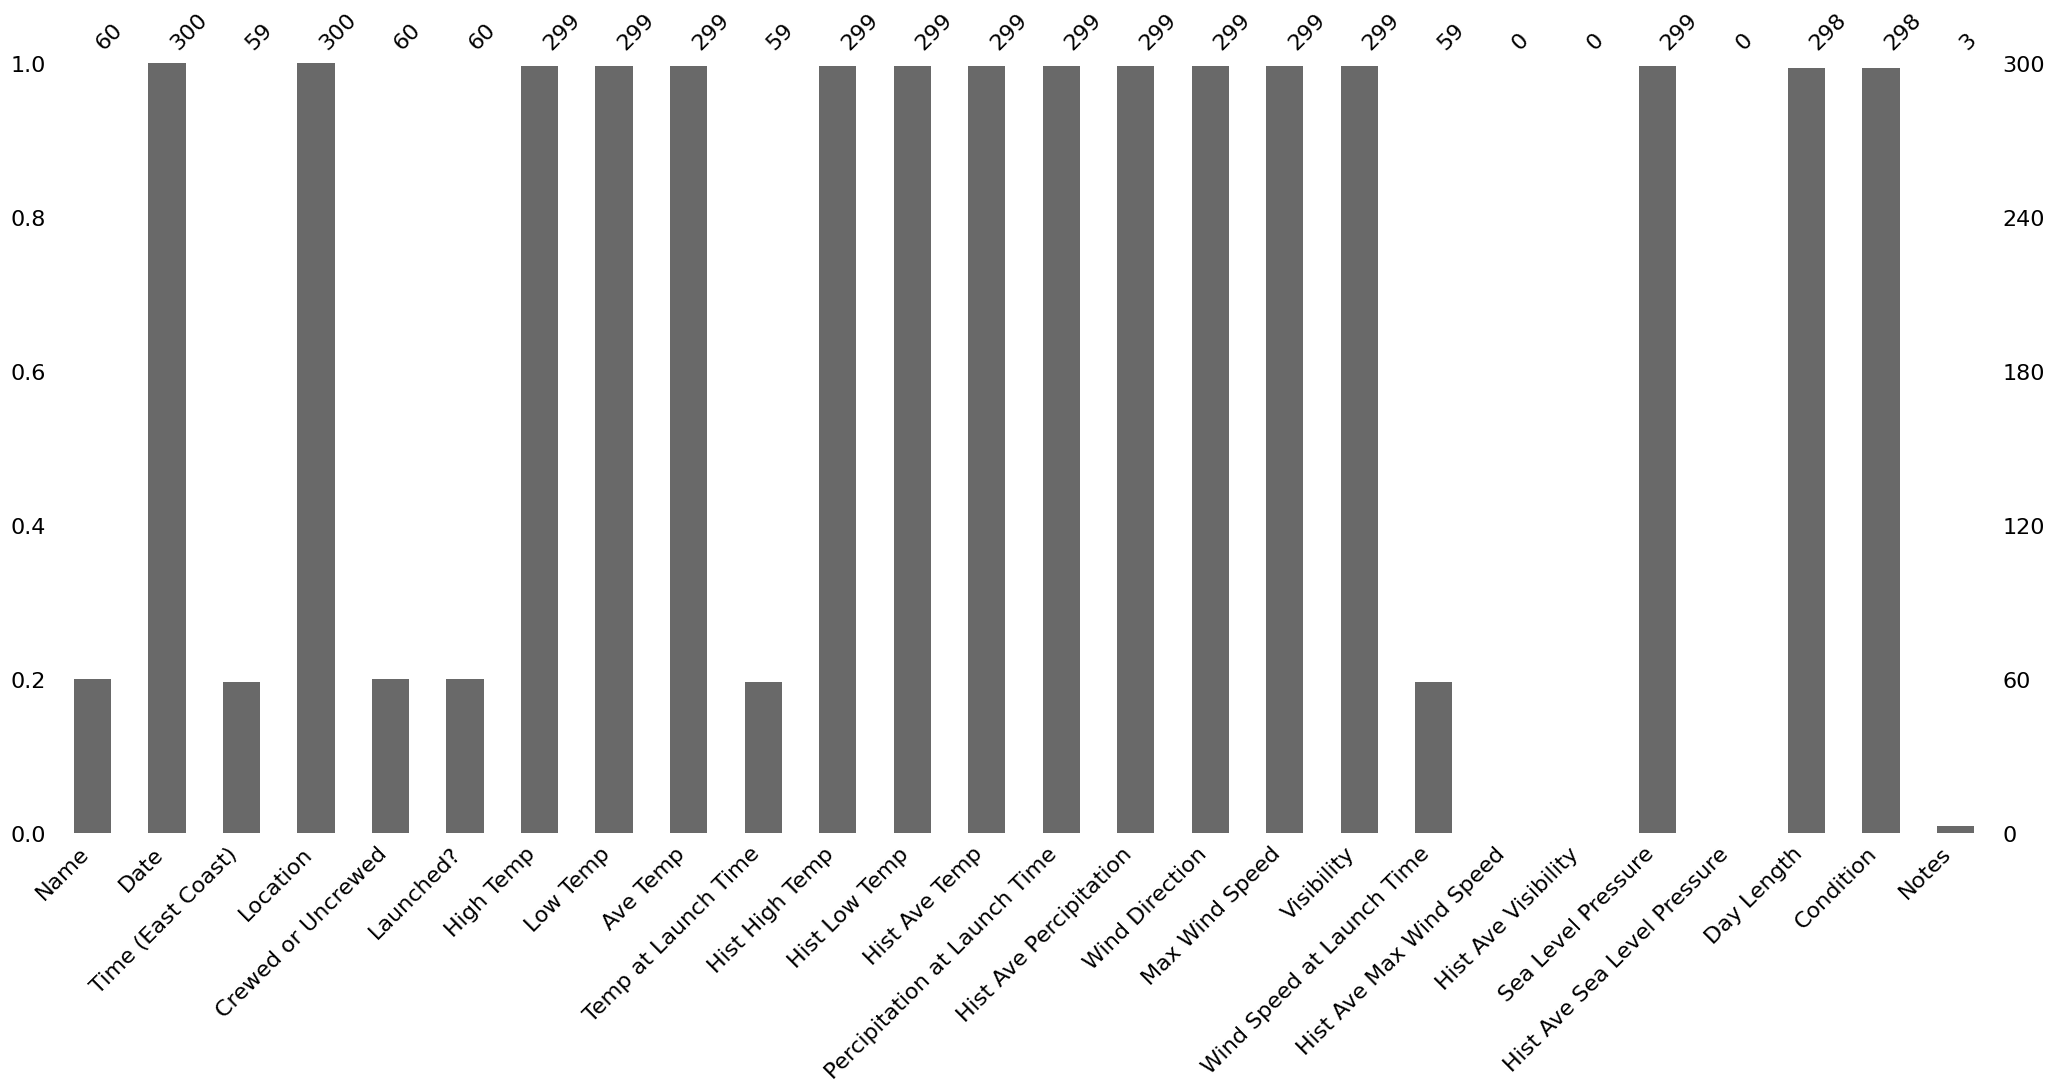

In [60]:
# pip install missingno
import missingno
plt.figure(figsize=(10,4))
missingno.bar(df)

#### 종속변수 결측치 처리


In [61]:
df['Launched?'] = df['Launched?'].fillna('N')

#### 사용하지 않을 컬럼 삭제

In [62]:
# ----------------------------------------------------------------------
# 관련도 낮음        
#    - Name, Date, Time (East Coast), Location
#    - Day Length, Notes, Sea Level Pressure
# ----------------------------------------------------------------------
drop_cols = ['Name',
            'Date',
            'Time (East Coast)',
            'Location',
            'Day Length',
            'Notes',
            'Sea Level Pressure']

df = df.drop(drop_cols, axis=1)

#### 결측치가 70% 미만인 데이터만 선택

In [63]:
df = df.loc[:, df.isnull().mean()<0.7]

#### 결측치 채우기

In [64]:
# ----------------------------------------------------------------------
#   Wind Direction      -> Unknown
#   Condition           -> Fail
# ----------------------------------------------------------------------
fill_cols = {
    'Wind Direction':'Unknown',
    'Condition':'Fail'
}
df = df.fillna(fill_cols)

In [65]:
# ----------------------------------------------------------------------
#   수치형 변수 -> 중앙값
# ----------------------------------------------------------------------
numerical_cols = df.select_dtypes(include='number').columns
numerical_cols
for col in numerical_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

### 독립변수, 종속변수 지정

In [66]:
X = df.drop('Launched?', axis=1)
y = df['Launched?']

In [67]:
# ---------------------------
# 종속변수 인코딩
# ---------------------------
df['Launched?'] = df['Launched?'].map({'Y':1, 'N':0})

### 훈련세트/테스트세트 분할

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((225, 12), (75, 12), (225,), (75,))

### 전처리 파이프라인

In [69]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# -----------------------------
# 전처리 대상 컬럼 지정
#   - categorical_features : 원‑핫 인코딩할 범주형 변수 목록
#   - numerical_features   : 표준화(평균 0, 표준편차 1)할 수치형 변수 목록
# -----------------------------
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(include='number').columns


# -----------------------------
# ColumnTransformer 구성
#   - "cat" : 범주형 → OneHotEncoder
#   - "num" : 수치형 → StandardScaler
#   remainder="passthrough" : transformers에 포함되지 않은 컬럼은 변환 없이 그대로 유지
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ],
    remainder="passthrough"   # drop 으로 바꾸면 나머지 컬럼을 제거
)

### 파이프라인 정의

In [70]:
# --------------------------------------------
# 파이프라인 정의
# --------------------------------------------
from sklearn.pipeline import Pipeline       
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', RandomForestClassifier())
])



#### RandomSearchCV

In [ ]:
# -----------------------------
# 하이퍼파라미터 공간 정의
# -----------------------------


In [ ]:
# -------------------------
# 랜덤서치CV 설정
# -------------------------



In [ ]:
# -------------------------
# 학습
# -------------------------


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               Index(['Wind Direction', 'Condition'], dtype='object')),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               Index(['High Temp', 'Low Temp', 'Ave Temp', 'Hist High Temp', 'Hist Low Temp',
       'Hist Ave Temp', 'Percipitation at Launch Ti...
       'Hist Ave Percipitation', 'Max Wind Speed', 'Visibility'],
      dtype='object'))])),
                                             ('dt', RandomForestClassifier())]),
                   n_iter=20,
                   param_distributions={'dt__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001750EAC5610>,
                                        'dt__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001750E65CD60>},
                   random_state=42, scoring='accuracy')

In [ ]:
# 결과 확인


최적 파라미터: {'dt__max_depth': 9, 'dt__min_samples_split': 5}
최고 평균 정확도: 0.8044444444444444


In [ ]:
# 최적 모델의 feature_importances_ 추출


In [ ]:
# 전처리기에서 전처리 후 컬럼 이름 얻기



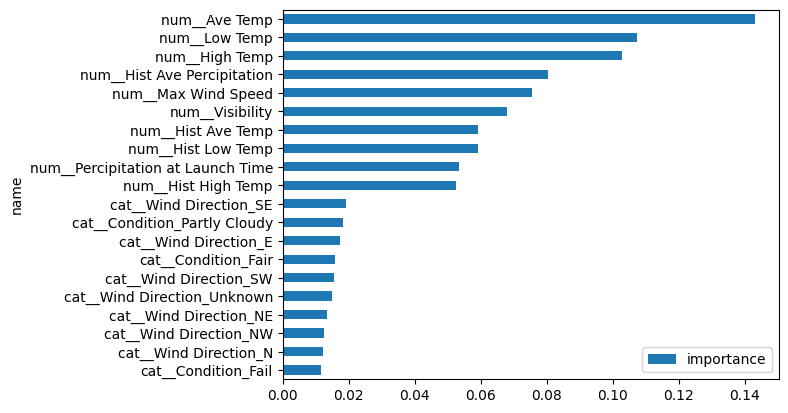